In [1266]:
!pip3 install matplotlib

In [1267]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import collections
from enum import Enum
from typing import List, Optional
from dataclasses import dataclass, field

origData = []
MIN_FILTER_SIZE = 3
MAX_FILTER_SIZE = 301
FILTER_SIZE = 33
FIG_SIZE = (250, 25)
FRAME_SIZE = 180
FRAME_LEN = 160
DBL_EPSILON = sys.float_info.epsilon
DBL_MAX = sys.float_info.max

In [1268]:
wfOrig = wave.open("raw_voice.wav", 'r')
origCh = wfOrig.getnchannels()
origSmpl = wfOrig.getsampwidth()
origRate = wfOrig.getframerate()
origNFrames = wfOrig.getnframes()
origData = wfOrig.readframes(origNFrames)
wfOrig.close()
print(f"Orig\n channels: {origCh}\n samples width: {origSmpl}\n frame rate: {origRate}\n frames: {origNFrames}\n data len: {len(origData)}")

Orig
 channels: 1
 samples width: 2
 frame rate: 8000
 frames: 242560
 data len: 485120


In [1270]:
@dataclass
class LocalGain:
    max_gain: float
    threshold: float

class CQueue:
    def __init__(self):
        self.elements = None
        self.size = 0
        self.max_size = 0
        self.nb_elements = 0
    
    def __repr__(self):
        return f"CQueue(size={self.size}, max_size={self.max_size}, nb_elements={self.nb_elements})"

def cqueue_create(size: int, max_size: int) -> CQueue:
    if (max_size < size):
        return None
    resQ = CQueue()
    resQ.max_size = max_size
    resQ.size = size
    resQ.nb_elements = 0
    resQ.elements = [0.0] * max_size
    return resQ

def cqueue_size(q: CQueue) -> int:
    return q.nb_elements

def cqueue_empty(q: CQueue) -> bool:
    return q.nb_elements <= 0

def cqueue_enqueue(q: CQueue, element: float):
    if not (q.nb_elements < q.max_size):
        return
    q.elements[q.nb_elements] = element
    q.nb_elements += 1

def cqueue_peek(q: CQueue, index: int) -> float:
    if not (index < q.nb_elements):
        return
    return q.elements[index]

def cqueue_dequeue(q: CQueue):
    if cqueue_empty(q):
        return
    element = q.elements[0]
    q.elements = q.elements[1:] + [0.0]
    q.nb_elements -= 1
    return element

def cqueue_pop(q: CQueue):
    if cqueue_empty(q):
        return
    q.elements = q.elements[1:] + [0.0]
    q.nb_elements -= 1

In [1271]:
class GaussianFilter:
    def __init__(self, filterSize: int):
        self.filter_size = filterSize
        self.sigma = (((float(self.filter_size) / 2.0) - 1.0) / 3.0) + (1.0 / 3.0)
        self.weights = np.zeros(MAX_FILTER_SIZE)
        total_weight = 0.0
        offset = int(self.filter_size / 2)
        c1 = 1.0 / (self.sigma * np.sqrt(2.0 * np.pi))
        c2 = 2.0 * np.pow(self.sigma, 2.0)
    
        for i in range(0, self.filter_size):
            x = i - offset
            # self.m_weights[i] = c1 * np.exp(np.pow(x, 2.0) * -1)
            self.weights[i] = c1 * math.exp(-x * x / c2)
            total_weight += self.weights[i]
    
        adjust = 1.0 / total_weight
        for i in range(0, self.filter_size):
            self.weights[i] *= adjust
    
        print(f"GaussFilter: filter size = {self.filter_size}, sigma = {self.sigma}")

    def filter(self, q: CQueue, tq: CQueue) -> float:
        # weights = self.weights
        result = 0.0
        tsum = 0.0
        for i in range(0, cqueue_size(q)):
            tq_item = cqueue_peek(tq, i)
            q_item = cqueue_peek(q, i)
            tsum += tq_item * self.weights[i]
            result += tq_item * self.weights[i] * q_item
        if (0.0 == tsum):
            result = 1.0
        return result

In [1272]:
# NOTE: frame->nb_samples == s->sample_advance == s->frame_len == self.frame_len
# NOTE: frame->extended_data[c] - сами данные

import random

class AGC:
    m_is_first_frame = True
    def __init__(self, channels: int, filterSize: int, sampleRate: int, frameLenMsec: int, maxAmplification: float):
        self.channels = channels
        self.filter_size = filterSize
        # self.m_sampleRate = sampleRate
        self.frame_len_msec = frameLenMsec
        self.frame_len = self.frame_size(sampleRate, self.frame_len_msec)
        self.prev_amplification_factor = np.ones(self.channels, dtype=float)
        self.dc_correction_value = np.ones(self.channels, dtype=float)

        self.gain_history_original = [cqueue_create(self.filter_size, MAX_FILTER_SIZE) for i in range(0, self.channels)]
        self.gain_history_minimum = [cqueue_create(self.filter_size, MAX_FILTER_SIZE) for i in range(0, self.channels)]
        self.gain_history_smoothed = [cqueue_create(self.filter_size, MAX_FILTER_SIZE) for i in range(0, self.channels)]
        self.threshold_history = [cqueue_create(self.filter_size, MAX_FILTER_SIZE) for i in range(0, self.channels)]
        
        # for c in range(0, self.channels):
        #     self.gain_history_original[c] = cqueue_create(self.filter_size, MAX_FILTER_SIZE)
        #     self.gain_history_minimum[c] = cqueue_create(self.filter_size, MAX_FILTER_SIZE)
        #     self.gain_history_smoothed[c] = cqueue_create(self.filter_size, MAX_FILTER_SIZE)
        #     self.threshold_history[c] = cqueue_create(self.filter_size, MAX_FILTER_SIZE)
        
        self.overlap = 0.0
        self.threshold = 0.0
        self.sample_advance = max(1, int(round(self.frame_len * (1.0 - self.overlap))))
        self.peak_value = 0.95
        self.max_amplification = maxAmplification # NOTE: коэф громкости
        self.gauss = GaussianFilter(self.filter_size)

    def frame_size(self, sampleRate: int, frameLenMsec: int) -> int:
        frameSize = int(round(float(sampleRate) * (frameLenMsec / 1000.0)))
        return frameSize + (frameSize % 2)
    
    def filter_frame(self, frame) -> int:
        if (not cqueue_empty(self.gain_history_smoothed[0])):
            for c in range(0, self.channels):
                self.amplify_channel(frame, c)
        self.analyze_frame(frame)
        return 1

    def analyze_frame(self, frame):
        self.perform_dc_correction(frame)

        for c in range(0, self.channels):
            maxLocalGain = self.get_max_local_gain(frame, self.channels)
            self.update_gain_history(c, maxLocalGain)

    def perform_dc_correction(self, frame):
        diff = 1.0 / self.frame_len
        for ch in range(0, self.channels):
            bypass = self.bypass_channel(frame, ch)
            current_average_value = 0.0
            prev_value = 0.0
            
            for i in range(0, self.frame_len):
                current_average_value += frame[i] * diff

            if (self.m_is_first_frame):
                prev_value = current_average_value
                self.dc_correction_value[ch] = current_average_value
            else:
                prev_value = self.dc_correction_value[ch]
                self.dc_correction_value[ch] = self.update_value(current_average_value, self.dc_correction_value[ch], 0.1)

            if (bypass):
                continue

            for i in range(0, self.frame_len):
                frame[i] -= self.fade(prev_value, self.dc_correction_value[ch], i, self.frame_len)
        
        self.m_is_first_frame = False

    def bypass_channel(self, frame, channel: int):
        return False

    def update_value(self, newVal: float, oldVal: float, aggressiveness: float) -> float:
        return aggressiveness * newVal + (1.0 - aggressiveness) * oldVal

    def fade(self, prevVal: float, nextVal: float, pos: int, length: int) -> float:
        step_size = 1.0 / length
        f0 = 1.0 - (step_size * (pos + 1.0))
        f1 = 1.0 - f0
        return f0 * prevVal + f1 * nextVal

    def update_gain_history(self, channel: int, gain: LocalGain):
        # TODO: продолжить тут
        if (cqueue_empty(self.gain_history_original[channel])):
            pre_fill_size = int(self.filter_size / 2)
            initial_value = float(min(1.0, gain.max_gain))
            self.prev_amplification_factor[channel] = initial_value
            while (cqueue_size(self.gain_history_original[channel]) < pre_fill_size):
                cqueue_enqueue(self.gain_history_original[channel], initial_value)
                cqueue_enqueue(self.threshold_history[channel], gain.threshold)

        cqueue_enqueue(self.gain_history_original[channel], gain.max_gain)

        while (cqueue_size(self.gain_history_original[channel]) >= self.filter_size):
            minimum = 0.0
            if (cqueue_empty(self.gain_history_minimum[channel])):
                pre_fill_size = int(self.filter_size / 2)
                initial_value = 1.0
                inputVal = pre_fill_size
                while (cqueue_size(self.gain_history_minimum[channel]) < pre_fill_size):
                    inputVal += 1
                    initial_value = float(min(initial_value, cqueue_peek(self.gain_history_original[channel], inputVal)))
                    cqueue_enqueue(self.gain_history_minimum[channel], initial_value)
            minimum = self.minimum_filter(self.gain_history_original[channel])
            cqueue_enqueue(self.gain_history_minimum[channel], minimum)
            cqueue_enqueue(self.threshold_history[channel], gain.threshold)
            cqueue_pop(self.gain_history_original[channel])

        while (cqueue_size(self.gain_history_minimum[channel]) >= self.filter_size):
            smoothed = 0.0
            limit = 0.0
            smoothed = self.gauss.filter(self.gain_history_minimum[channel], self.threshold_history[channel])
            limit = cqueue_peek(self.gain_history_original[channel], 0)
            smoothed = min(smoothed, limit)
            cqueue_enqueue(self.gain_history_smoothed[channel], smoothed)
            cqueue_pop(self.gain_history_minimum[channel])
            cqueue_pop(self.threshold_history[channel])
                    
    def get_max_local_gain(self, frame, channel: int) -> LocalGain:
        peak_magnitude = self.find_peak_magnitude(frame, channel)
        maximum_gain = self.peak_value / peak_magnitude
        rms_gain = DBL_MAX
        target_gain = DBL_MAX
        maxGain = self.bound(self.max_amplification, min(target_gain, min(maximum_gain, rms_gain)))
        gain = LocalGain(max_gain=maxGain, threshold=(peak_magnitude > self.threshold))
        return gain

    def find_peak_magnitude(self, frame, channel: int) -> float:
        maxVal = DBL_EPSILON
        if (-1 == channel):
            for c in range(0, self.channels):
                for i in range(0, self.frame_len):
                    maxVal = max(maxVal, math.fabs(frame[i]))
        else:
            for i in range(0, self.frame_len):
                maxVal = max(maxVal, math.fabs(frame[i]))
                
        return maxVal

    def bound(self, threshold: float, val: float) -> float:
        # CONST = 0.8862269254527580136490837416705725913987747280611935; # NOTE: sqrt(PI) / 2.0
        CONST = math.sqrt(math.pi) / 2
        return (math.erf(CONST * (val / threshold)) * threshold)

    def minimum_filter(self, q: CQueue) -> float:
        minVal = DBL_MAX
        for i in range(0, cqueue_size(q)):
            minVal = min(minVal, cqueue_peek(q, i))
        return minVal

    def amplify_channel(self, frame, channel: int):
        bypass = self.bypass_channel(frame, channel)
        current_amplification_factor = cqueue_dequeue(self.gain_history_smoothed[channel])
        for i in range(0, self.frame_len):
            amplification_factor = self.fade(self.prev_amplification_factor[channel], current_amplification_factor, i, self.frame_len)
            # print(f"amplification_factor = {amplification_factor}, frame[i] = {frame[i]}")
            try:
                frame[i] = frame[i] * amplification_factor
            except Exception:
                pass
        self.prev_amplification_factor[channel] = current_amplification_factor
        

In [1273]:
origPlotData = np.frombuffer(origData, np.int16)
origDataLen = len(origPlotData)
time = np.linspace(0, origDataLen / origRate, num = origDataLen)
plt.figure(figsize = FIG_SIZE, dpi = 150)
plt.xlabel("Time (s)")
plt.ylabel("Hz")
plt.title("Original wave")
plt.plot(time, origPlotData)
plt.show()

In [1274]:
processedData = origPlotData.copy()
processedDataLen = len(processedData)
print(f"len = {processedDataLen}")
FRAME_LEN_MSEC = 20
flag = True
MAX_AMPLIFICATION = 90.0 # int(0.9 * max_int16)

agc = AGC(origCh, FILTER_SIZE, origRate, FRAME_LEN_MSEC, MAX_AMPLIFICATION)

def dummy_agc(arr):
    half_max = int(np.iinfo(np.int16).max / 2)
    half_min = int(np.iinfo(np.int16).min / 2)
    for i in range(0, len(arr)):
        if (arr[i] > half_min and arr[i] < half_max):
            arr[i] *= 2

for i in range(0, processedDataLen, agc.frame_len):
    subStep = i + agc.frame_len
    if (subStep >= processedDataLen):
        break

    # TODO: передавать в обработку data[i, subStep]
    # print("before = ", processedData[i:subStep])
    # print(f"len={len(processedData[i:subStep])}") # NOTE: len=160
    agc.filter_frame(processedData[i:subStep])

    # arrayInputUint = np.array(processedData[i:subStep], dtype=np.uint16)
    # agc.filter_frame(arrayInputUint)
    # for j in range(i, subStep):    
    #     processedData[j] = np.int16(arrayInputUint[j - i]) # np.array(arrayInputUint, dtype=np.int16)
    
    # agc.perform_dc_correction(processedData[i:subStep])
    # dummy_agc(processedData[i:subStep])


    if flag:
        flag = False
    else:
        flag = True

len = 242560
GaussFilter: filter size = 33, sigma = 5.5


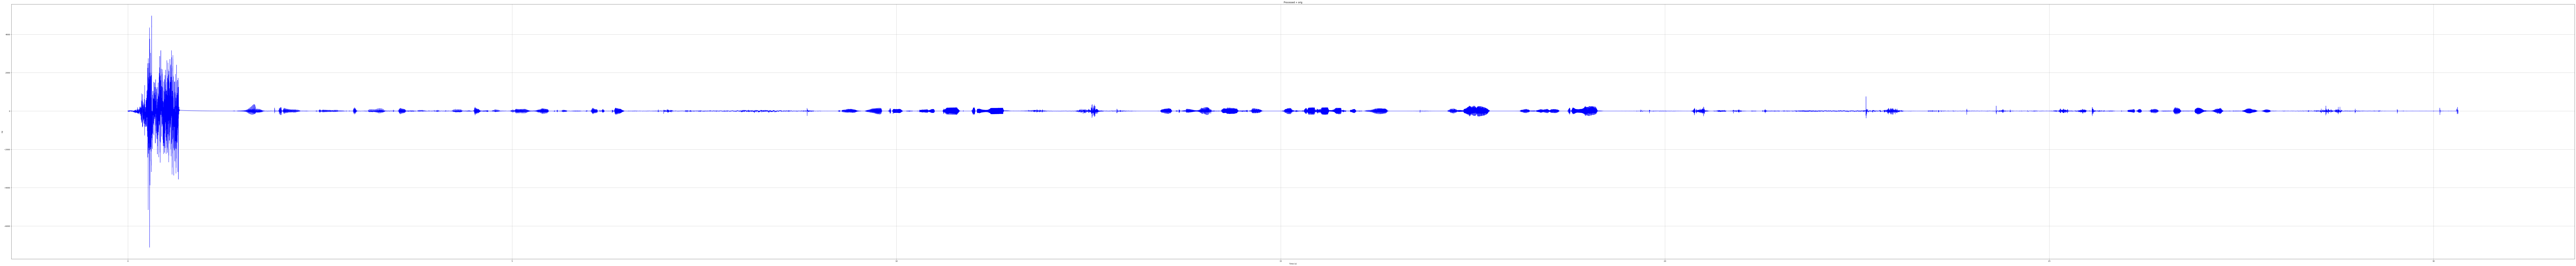

In [1275]:
plt.figure(figsize = FIG_SIZE)
plt.xlabel("Time (s)")
plt.ylabel("Hz")
plt.title("Processed + orig")

plt.plot(time, processedData, color = 'b')
# plt.plot(time, origPlotData, color = 'r')
plt.grid(True)
plt.show()
with wave.open("processed_py.wav", 'wb') as wav_file_ouput:
    wav_file_ouput.setnchannels(1)
    wav_file_ouput.setsampwidth(2)
    wav_file_ouput.setframerate(8000)
    wav_file_ouput.writeframesraw(processedData.tobytes())